#Descrizione

In questo notebook vengono testati diversi metodi per ottenere la bidirezionalità.

Modello su database da 18k; rete bidirezionale LSTM (CuDNN).

Parametri:

1.   2 layer da 141 nodi, 94 nodi;
2.   Immagini 64x64; le immagini sono Nx64, se N > 64, vengono troncate, se N < 64, faccio padding;
3.   1024 batch size;
4.   Accuratezza finale: 81%.

(Patience = 5).

##Risultati dei modelli

*   Sum: 77,5%
*   Mul: 65,4%
*   Ave: 44,3%
*   Concat (default): 81,7%




In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


#Import

In [2]:
import tensorflow as tf
from tensorflow import keras as ks

import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from skimage.transform import resize

import cv2

#Data visualization
import seaborn as sns

from matplotlib import pyplot as plt

import glob
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os, os.path

#Per modello NN
from tensorflow.keras import layers
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Softmax
from tensorflow.keras.layers import Dropout

import time
import math

print(tf.__version__)

1.15.2


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


##Defining methods

In [3]:
#Extract the class from the file name, if the class is the string before che -
def extract_label(from_string):
  position = from_string.index('-') # gets position of the - in the filename
  substring = from_string[0:position]
  return substring

def extract_obf(from_string):
  start_pos = from_string.index('-')
  end_pos = from_string.index('.')
  substring = from_string[(start_pos + 1):end_pos]
  return substring

def mapping_labels_encoded(label_encoder):
  for index in range(len(list(label_encoder.classes_))):
    print(index, end = "-> ")
    print(list(label_encoder.inverse_transform([index]))) 

class TimeHistory(ks.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')


print("Done")

Done


#Import database

In [4]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
downloaded = drive.CreateFile({'id':"18ESID3MpwG-SzZPE1EENzsGPh8vl8ti9"})   # replace the id with id of file you want to access
downloaded.GetContentFile('data_18800.zip')        # replace the file name with your file

In [6]:
!unzip -q data_18800.zip -d DB_Repo/

print("Done")

Done


In [7]:
path, dirs, files = next(os.walk("/content/DB_Repo/data"))
file_count = len(files)
#Should be 18800
print(file_count)

18800


In [8]:
%cd /content/DB_Repo/data
!pwd

/content/DB_Repo/data
/content/DB_Repo/data


##Lettura database, resize immagini

In [9]:
##PARAMETERS

batch_size = 2048

#Unit in first layer
num_units1 = 141
num_units2 = 94

new_dim = 64
MAX_LEN = 64 #fisso
channels = 1

time_steps = new_dim
n_features = MAX_LEN
#size_ts_blocks = 8

n_epochs = 100

#Considero il primo 20% della lista di dati come test set
test_percentage = 20 #%
#Considero il 20% della lista di dati - esclusi i dati di test - come validation set
validation_percentage = 20 #%

In [10]:
#COSTANTI E DICHIARAZIONI

database_list = list()
labels_list = list()
obf_list = list()

In [11]:
#LETTURA E RESIZE IMMAGINI

print("START IMAGE INPUT")
#Aggiungo i valori alle liste leggendo i vari files
for filename in glob.glob('*.npy'):
  temp_img = np.load(filename)
  temp_img = temp_img.reshape((-1, MAX_LEN)).astype('float32') 
  dimStrana, _ = temp_img.shape
  #print("prima: ", temp_img.shape)
  if dimStrana <= 64:
    temp_img = np.pad(temp_img, ((0, 64 - dimStrana),(0,0)), mode='constant',constant_values=0)
  elif dimStrana > 64:
    temp_img = temp_img[0:64, 0:64]
  else:
    print("ERROR")
    quit()
  #print("dopo: ", temp_img.shape)
  #temp_img = cv2.resize(temp_img, (MAX_LEN, new_dim), interpolation=cv2.INTER_CUBIC)
  database_list.append(temp_img)
  #Salvo la label, ossia la classe
  labels_list.append(extract_label(filename))
  #Salvo la lista di offuscatori di ogni file
  obf_list.append(extract_obf(filename))
print("END IMAGE INPUT")

START IMAGE INPUT
END IMAGE INPUT


In [12]:
#SHUFFLE

#Ho i valori e le etichette in due liste (+ obf); 
#le mescolo mantenendo l'ordine tra valore-label
temp = list(zip(database_list, labels_list, obf_list))
np.random.shuffle(temp)
database_list, labels_list, obf_list = zip(*temp)

In [13]:
#SUDDIVISIONE DATI
#Suddivido in training set, test set e validation test
assert len(database_list) == len(labels_list) == len(obf_list)
print(len(database_list))

#Split per creare test set
index_to_split = math.ceil((len(database_list) * test_percentage) / 100)
indices = [(0, index_to_split - 1), (index_to_split, len(database_list) - 1)]

test_list, training_list = [database_list[s:e+1] for s,e in indices]
labels_test_list, labels_training_list = [labels_list[s:e+1] for s,e in indices]
obf_test_list, obf_training_list = [obf_list[s:e+1] for s,e in indices]

#Split per creare validation set
index_to_split = math.ceil((len(training_list) * validation_percentage) / 100)
indices = [(0, index_to_split - 1), (index_to_split, len(training_list) - 1)]

validation_list, training_list = [training_list[s:e+1] for s,e in indices]
labels_validation_list, labels_training_list = [labels_training_list[s:e+1] for s,e in indices]
obf_validation_list, obf_training_list = [obf_training_list[s:e+1] for s,e in indices]

18800


In [14]:
#Trasformo i valori in numpy.ndarray
train_images = np.array(training_list)
test_images = np.array(test_list)
validation_images = np.array(validation_list)

train_labels = np.array(labels_training_list)
test_labels = np.array(labels_test_list)
validation_labels = np.array(labels_validation_list)

train_obf = np.array(obf_training_list)
test_obf = np.array(obf_test_list)
validation_obf = np.array(obf_validation_list)

In [15]:
#Encoding delle labels;
#Se nella suddivisione il 100% di una classe è fuori dal train_labels,
#Vi sarà un errore nell'encoding delle labels negli altri set.
label_encoder = LabelEncoder()
label_encoder.fit(train_labels)
train_labels_encoded = label_encoder.transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)
validation_labels_encoded = label_encoder.transform(validation_labels)

In [16]:
#Normalizzazione valori in range 0-1
train_images = train_images / 65535.0
test_images = test_images / 65535.0
validation_images = validation_images / 65535.0

In [17]:
#Dopo la normalizzazione, va rifatto il cast

train_images = train_images.reshape(-1, new_dim, MAX_LEN).astype(np.single)
test_images = test_images.reshape(-1, new_dim, MAX_LEN).astype(np.single)
validation_images = validation_images.reshape(-1, new_dim, MAX_LEN).astype(np.single)

In [18]:
#Dichiarazione altri parametri
n_classes = len(list(label_encoder.classes_))

#Definizione modelli di rete neurale

In [19]:
tf.reset_default_graph()

In [20]:
modelLSTM = ks.Sequential()

#Batch size should be (at most) the same number of hidden cells
#no activation selection
modelLSTM.add(Bidirectional(CuDNNLSTM(num_units1, unit_forget_bias='true', return_sequences='true'),
                            input_shape=(time_steps, n_features), merge_mode='sum'))
modelLSTM.add(Bidirectional(CuDNNLSTM(num_units2, unit_forget_bias='true'), merge_mode='sum'))
modelLSTM.add(Dense(n_classes, activation='softmax'))

modelLSTM.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Definizione callback
es = ks.callbacks.EarlyStopping(monitor='val_loss', patience=5,
                                mode='auto', restore_best_weights=True, verbose=1)
time_callback = TimeHistory()

#Validation_data è usato al termine di ogni epoch;
hist = modelLSTM.fit(train_images, train_labels_encoded, 
                    batch_size = batch_size,
                    validation_data=(test_images, test_labels_encoded), 
                    epochs=n_epochs, shuffle='true',
                    callbacks=[time_callback, es], verbose=0)

number_of_epochs_it_ran = len(hist.history['loss'])

time_per_epoch = time_callback.times
total_time = sum(time_per_epoch)
print("Total epochs", number_of_epochs_it_ran)
print(str(total_time), "s")
test_accuracy = modelLSTM.evaluate(validation_images, validation_labels_encoded)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Restoring model weights from the end of the best epoch.
Epoch 00081: early stopping
Total epochs 81
236.2097761631012 s
3008/3008 [==============================] - 2s 623us/sample - loss: 0.9111 - acc: 0.7749


In [21]:
modelLSTM2 = ks.Sequential()

#Batch size should be (at most) the same number of hidden cells
#no activation selection
modelLSTM2.add(Bidirectional(CuDNNLSTM(num_units1, unit_forget_bias='true', return_sequences='true'),
                            input_shape=(time_steps, n_features), merge_mode='sum'))
modelLSTM2.add(Bidirectional(CuDNNLSTM(num_units2, unit_forget_bias='true'), merge_mode='mul'))
modelLSTM2.add(Dense(n_classes, activation='softmax'))

modelLSTM2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Definizione callback
es = ks.callbacks.EarlyStopping(monitor='val_loss', patience=5,
                                mode='auto', restore_best_weights=True, verbose=1)
time_callback2 = TimeHistory()

#Validation_data è usato al termine di ogni epoch;
hist2 = modelLSTM2.fit(train_images, train_labels_encoded, 
                    batch_size = batch_size,
                    validation_data=(test_images, test_labels_encoded), 
                    epochs=n_epochs, shuffle='true',
                    callbacks=[time_callback2, es], verbose=0)

number_of_epochs_it_ran = len(hist2.history['loss'])

time_per_epoch = time_callback2.times
total_time = sum(time_per_epoch)
print("Total epochs", number_of_epochs_it_ran)
print(str(total_time), "s")
test_accuracy2 = modelLSTM2.evaluate(validation_images, validation_labels_encoded)

Restoring model weights from the end of the best epoch.
Epoch 00089: early stopping
Total epochs 89
252.38224864006042 s
3008/3008 [==============================] - 2s 603us/sample - loss: 1.3394 - acc: 0.6536


In [22]:
modelLSTM3 = ks.Sequential()

#Batch size should be (at most) the same number of hidden cells
#no activation selection
modelLSTM3.add(Bidirectional(CuDNNLSTM(num_units1, unit_forget_bias='true', return_sequences='true'),
                            input_shape=(time_steps, n_features), merge_mode='ave'))
modelLSTM3.add(Bidirectional(CuDNNLSTM(num_units2, unit_forget_bias='true'), merge_mode='ave'))
modelLSTM3.add(Dense(n_classes, activation='softmax'))

modelLSTM3.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Definizione callback
es = ks.callbacks.EarlyStopping(monitor='val_loss', patience=5,
                                mode='auto', restore_best_weights=True, verbose=1)
time_callback3 = TimeHistory()

#Validation_data è usato al termine di ogni epoch;
hist3 = modelLSTM3.fit(train_images, train_labels_encoded, 
                    batch_size = batch_size,
                    validation_data=(test_images, test_labels_encoded), 
                    epochs=n_epochs, shuffle='true',
                    callbacks=[time_callback3, es], verbose=0)

number_of_epochs_it_ran = len(hist3.history['loss'])

time_per_epoch = time_callback.times
total_time = sum(time_per_epoch)
print("Total epochs", number_of_epochs_it_ran)
print(str(total_time), "s")
test_accuracy3 = modelLSTM3.evaluate(validation_images, validation_labels_encoded)

Restoring model weights from the end of the best epoch.
Epoch 00054: early stopping
Total epochs 54
236.2097761631012 s
3008/3008 [==============================] - 2s 607us/sample - loss: 1.9440 - acc: 0.4425


In [23]:
modelLSTM4 = ks.Sequential()

#Batch size should be (at most) the same number of hidden cells
#no activation selection
modelLSTM4.add(Bidirectional(CuDNNLSTM(num_units1, unit_forget_bias='true', return_sequences='true'),
                            input_shape=(time_steps, n_features)))
modelLSTM4.add(Bidirectional(CuDNNLSTM(num_units2, unit_forget_bias='true')))
modelLSTM4.add(Dense(n_classes, activation='softmax'))

modelLSTM4.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Definizione callback
es = ks.callbacks.EarlyStopping(monitor='val_loss', patience=5,
                                mode='auto', restore_best_weights=True, verbose=1)
time_callback4 = TimeHistory()

#Validation_data è usato al termine di ogni epoch;
hist4 = modelLSTM4.fit(train_images, train_labels_encoded, 
                    batch_size = batch_size,
                    validation_data=(test_images, test_labels_encoded), 
                    epochs=n_epochs, shuffle='true',
                    callbacks=[time_callback4, es], verbose=0)

number_of_epochs_it_ran = len(hist4.history['loss'])

time_per_epoch = time_callback.times
total_time = sum(time_per_epoch)
print("Total epochs", number_of_epochs_it_ran)
print(str(total_time), "s")
test_accuracy4 = modelLSTM4.evaluate(validation_images, validation_labels_encoded)

Total epochs 100
236.2097761631012 s
3008/3008 [==============================] - 2s 626us/sample - loss: 0.7694 - acc: 0.8165


#Risultati dei modelli

*   Sum: 77,5%
*   Mul: 65,4%
*   Ave: 44,3%
*   Concat (default): 81,7%


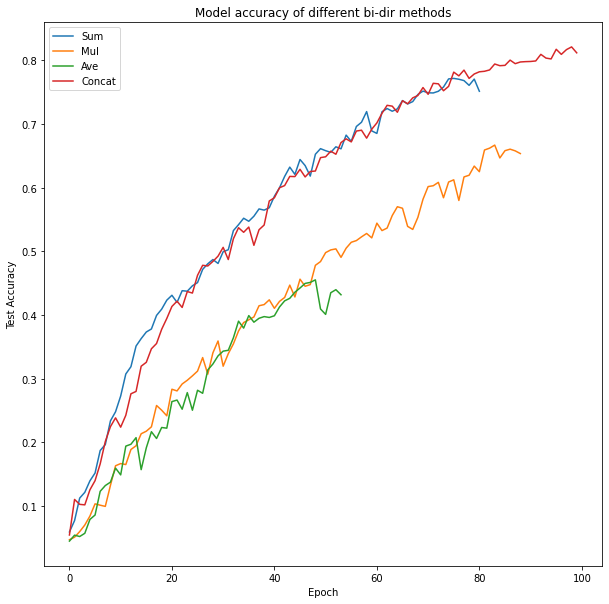

In [24]:
#Plot training & validation accuracy values
plt.figure(figsize=(10, 10))

plt.plot(hist.history['val_acc'])
plt.plot(hist2.history['val_acc'])
plt.plot(hist3.history['val_acc'])
plt.plot(hist4.history['val_acc'])
plt.title('Model accuracy of different bi-dir methods')
plt.ylabel('Test Accuracy')
plt.xlabel('Epoch')
plt.legend(['Sum', 'Mul', 'Ave', 'Concat'], loc='upper left')
plt.show()

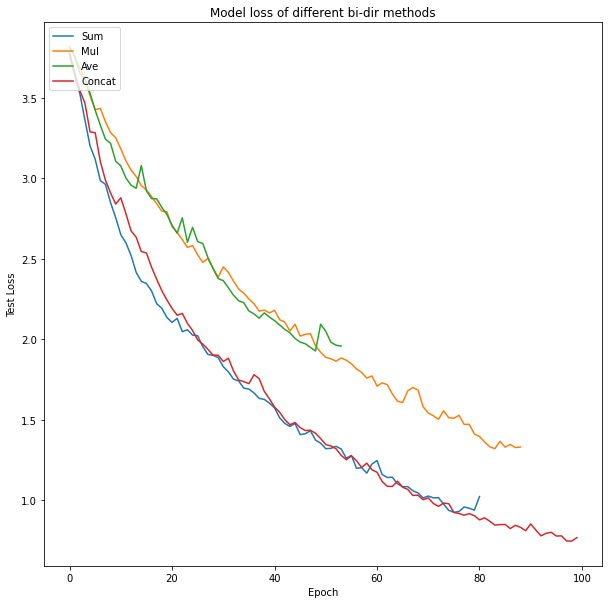

In [25]:
#Plot training & validation accuracy values
plt.figure(figsize=(10, 10))

plt.plot(hist.history['val_loss'])
plt.plot(hist2.history['val_loss'])
plt.plot(hist3.history['val_loss'])
plt.plot(hist4.history['val_loss'])
plt.title('Model loss of different bi-dir methods')
plt.ylabel('Test Loss')
plt.xlabel('Epoch')
plt.legend(['Sum', 'Mul', 'Ave', 'Concat'], loc='upper left')
plt.show()